In [ ]:
import sys
import os
import math

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision

import nvidia
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali.plugin.pytorch import DALIGenericIterator as PyTorchIterator
from nvidia.dali.plugin.pytorch import LastBatchPolicy

sys.path.append(os.path.abspath('flownet2'))
sys.path.append(os.path.abspath('flownet2/utils'))
from models import FlowNet2, FlowNet2SD
import flow_utils

import torchvision.models as models
import pytorch_msssim 

import time

# allow maximum memory per GPU
torch.cuda.set_per_process_memory_fraction(1.0, 0)

%matplotlib inline

In [ ]:
print('Using CUDA', torch.version.cuda)

Using CUDA 11.6


In [ ]:
## Hyperparameters

batch_size = 2
workspace = '.'

# Video Loading Parameters

# command to convert obs recording to hevc for dali: 
# ffmpeg -i bf4_rawdata.avi -c:v libx265 -x265-params lossless=1 -vtag hvc1 -c:a copy -an output.mp4
video_file = workspace + '/bf4_short.mp4'
sequence_length = 5                       # Number of frames per data sequence
initial_prefetch_size = 2                 # look at DALI docs. Probably number of samples to prefetch
original_video_size = (1920, 1080)        # The original size of the recording
hires_sf = 3                              # 1/Scalefactor applied to original resolution image. hires_img = (1920x1080) / hires_sf
lores_sf = 8                              # 1/Scalefactor applied to original resolution image. lores_img = (1920x1080) / lores_sf
frame_stride = 2                          # Space btwn sampling frames. stride=1 --> 60fps, stride=2 --> 30fps, stride=3 --> 20fps ...

print("Reference Video Size:", np.array(original_video_size)/hires_sf)
print("Low Resolution Video Size:", np.array(original_video_size)/lores_sf)
print("Upscaling by", lores_sf/hires_sf)

Reference Video Size: [640. 360.]
Low Resolution Video Size: [240. 135.]
Upscaling by 2.6666666666666665


In [ ]:
class DataFactory():
    def __init__(self, flow_model_type='FlowNet2', depth_model_type='DPT_Hybrid'):
        #model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
        #model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
        #model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

        self.midas = torch.hub.load("intel-isl/MiDaS", depth_model_type)
        self.midas.cuda()
        self.midas.eval()
        midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
        if flow_model_type == "DPT_Large" or flow_model_type == "DPT_Hybrid":
            self.transform = midas_transforms.dpt_transform
        else:
            self.transform = midas_transforms.small_transform
        
        class args: pass
        args.rgb_max = 1 
        
        if flow_model_type == 'FlowNet2':
            print("Using FlowNet2...")
            args.fp16 = False
            self.flownet = FlowNet2(args)
            self.flownet.load_state_dict(torch.load('./pretrained/FlowNet2_checkpoint.pth.tar')['state_dict'])
        elif flow_model_type == 'FlowNet2-SD':
            print("Using FlowNet2-SD...")
            args.fp16 = True
            self.flownet = FlowNet2SD(args)
            self.flownet.load_state_dict(torch.load('./pretrained/FlowNet2-SD_checkpoint.pth.tar')['state_dict'])
        else:
            print("invalid flownet")
            assert "Invalid flownet"
        
            
        self.flownet = self.flownet.cuda()
        self.flownet.eval()
        
        self.pipe = None
            
        
    def depth(self, input_batch): 
        """ Computes Depth on a batch of images using MiDaS """
        with torch.no_grad():
            prediction = self.midas(input_batch)
        return prediction / torch.max(prediction)
    
    def flow(self, x):
        """ Computes Depth on a batch of images using FlowNet2 """
        with torch.no_grad():
            prediction = self.flownet(x)
        return prediction 
    
    def get_dali_iterator(self):
        """ 
        Creates a DALI pipeline for loading video data and doing 
        basic pre-processing on it. Returns a PyTorch friendly iterator
        """
        @pipeline_def
        def video_pipe(lores_sf, hires_sf, stride, square_shape):
            out = fn.readers.video(
                device="gpu", 
                sequence_length=sequence_length, 
                random_shuffle=True, 
                file_list="filelist.txt",
                file_list_frame_num=True,
                enable_frame_num=True, 
                initial_fill=initial_prefetch_size,
                stride=stride,
                name="Reader")
            video = out[0]
            lores = fn.resize(video, resize_x=original_video_size[0]//lores_sf)

            if hires_sf != 1: 
                hires = fn.resize(video, resize_x=original_video_size[0]//hires_sf)
            else:
                hires = video

            # Switch to (N, Frames, C, H, W)
            hires = fn.transpose(hires, perm=[0, 3, 1, 2]) 
            lores = fn.transpose(lores, perm=[0, 3, 1, 2]) 

            # Convert to 0-1 range
            lores /= 255
            hires /= 255

            # pre-transform depth for MiDas network
            depth = (hires - 0.5) * 2
            depth = fn.resize(depth, resize_y=192, resize_x=384, 
                              interp_type=nvidia.dali.types.DALIInterpType.INTERP_CUBIC)

            square = fn.resize(hires, 
                               resize_y=square_shape[1]//lores_sf, 
                               resize_x=square_shape[0]//lores_sf, 
                               interp_type=nvidia.dali.types.DALIInterpType.INTERP_CUBIC)

            return out[2], lores, hires, depth, square

        nearest_square_shape = int(2**round(math.log(original_video_size[0], 2))), \
                               int(2**round(math.log(original_video_size[1], 2)))
        self.pipe = video_pipe(lores_sf, hires_sf, frame_stride, nearest_square_shape, 
                          batch_size=batch_size, num_threads=2, device_id=0, seed=12345)
        self.pipe.build()
        pii = PyTorchIterator(self.pipe, ['frame', 'lores', 'hires', 'depth', 'square'], 
                              reader_name="Reader", last_batch_policy=LastBatchPolicy.PARTIAL)
        
        return pii

    def get_epoch_size(self):
        return self.pipe.epoch_size()

    def pre_compute_data_from_iter(self, data):
        """ 
        Computes Optic Flow and Depth for a batch of video sequences returned 
        from the DALI pipeline and its iterator. 
        """
        lores = data[0]['lores']
        hires = data[0]['hires']
        depth = data[0]['depth']
        square = data[0]['square']
        start_frame = data[0]['frame']

        # compute depth over batch * frame dimension: (N, frames, 1, H, W)
        depth = self.depth(depth.flatten(0, 1))
        depth = depth.unflatten(0, (batch_size, sequence_length)).unsqueeze(2)
        depth = nn.functional.interpolate(depth, [1] + list(square.shape[3:]))

        # get RGBD for each frame
        rgbd = torch.cat((square, depth), axis=2)

        # pre-allocate the flow tensor (N, Frames-1, 2, H, W)
        flows = torch.empty(*([batch_size, 4, 2] + list(square.shape)[3:]), device=0)
        for i in range(batch_size): 
            batch = square[i, ...]
            # pre-allocate the temporally continuous frames for this batch 
            inp = torch.empty(*([4, 3, 2] + list(batch.shape)[2:]), device=0)
            # concatenate adjacent frames for input into flownet 
            for p in range(4): 
                pair = batch[p:p+2, ...]
                inp[p, ...] = pair.transpose(1, 0)
            # execute flownet on the frame batch and add it to the main flow tensor
            flows[i, ...] = self.flow(inp)
        
        return start_frame, hires, rgbd, flows




In [ ]:
dataf = DataFactory(flow_model_type='FlowNet2-SD')
dataf_iter = dataf.get_dali_iterator()

Using cache found in /home/tjz/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/tjz/.cache/torch/hub/intel-isl_MiDaS_master


Using FlowNet2-SD...


In [ ]:
def train():
    print('epoch_size=', dataf.get_epoch_size())
    epochs = 1
    hires = None
    rgbd = None
    flows = None
    for e in range(epochs):
        for i, data in enumerate(dataf_iter):
            start_frame, hires, rgbd, flows = dataf.pre_compute_data_from_iter(data)
            
            # at this point, we have a batch of: 
            # --------------
            # hires  = reference high resolution goal
            # rgbd   = low resolution RGB-Depth tensor for 5 frames
            # flows  = 4 frames of optica flow calculated as delta between the 5 frames
            # start_frame = frame when this sequence begins in the original data
            
            
            print("epoch: {}, frame={} iter {}, real batch size: {}".format(e, start_frame, i, 0))
            break
        dataf_iter.reset()
    return hires, rgbd, flows
hires, rgbd, flows = train()

epoch_size= {'Reader': 10}


epoch: 0, frame=tensor([[300],
        [340]], device='cuda:0', dtype=torch.int32) iter 0, real batch size: 0


In [ ]:
def display_image_in_actual_size(im_path):

    dpi = mpl.rcParams['figure.dpi']
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

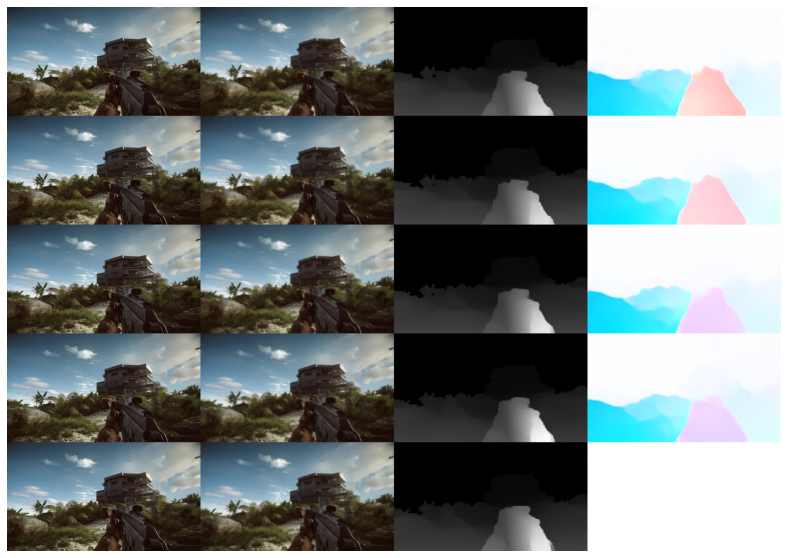

In [ ]:
def viz_datachunk(hires, rgbd, flows, batch_idx=0, roi=None):
    """ 
    Draws the high resolution and low resolution samples side by side.
    As time passes, draws vertically downard.
    
    Args:
        hires, rgbd, flows: output from DataFactory
        batch_idx (int):   which batch to visualize
        roi (list-like):   region of interest. [x, y, height, width]
    """
    hires = hires.cpu().detach().numpy()
    rgbd = rgbd.cpu().detach().numpy()
    flows = flows.cpu().detach().numpy()
    
    lo = rgbd[:, :, 0:3, ...]
    hi = hires
    dpt = rgbd[:, :, 3, ...]
    
    vstack = []
    for i in range(lo.shape[1]):
        h = hi[batch_idx][i].transpose(1, 2, 0)
        l = lo[batch_idx][i].transpose(1, 2, 0)
        d = dpt[batch_idx][i]
        
        if i < 4:
            f = flows[batch_idx][i].transpose(1, 2, 0)
            f = flow_utils.flow2img(f) / 255
        else: 
            f = np.ones(h.shape)
        
        upscaled = cv2.resize(l, (h.shape[1], h.shape[0]), interpolation=cv2.INTER_NEAREST)
        dscaled = cv2.resize(d, (h.shape[1], h.shape[0]), interpolation=cv2.INTER_NEAREST)
        f = cv2.resize(f, (h.shape[1], h.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        if roi is not None:
            x, y, height, width = roi
            h = h[y:y+height, x:x+width, :]
            upscaled = upscaled[y:y+height, x:x+width, :]
            dscaled = dscaled[y:y+height, x:x+width, :]
            f = f[y:y+height, x:x+width, :]
            
        dscaled = np.stack((dscaled, dscaled, dscaled), axis=-1)
        img = np.hstack([h, upscaled, dscaled, f])
        vstack.append(img)

    vid = np.vstack(vstack)
    # save resolution accurate image
    plt.imsave(fname='test.png', arr=vid,  format='png')

    # display image in jupyter
    fig = plt.figure(figsize=(20, 10))
    ax = plt.gca()
    ax.axis('off')
    plt.imshow(plt.imread('test.png'))
viz_datachunk(hires, rgbd, flows, 0)

In [ ]:
def _run_optic_flow(image_1, image_2):
    images = np.array([image_1, image_2]).transpose(3, 0, 1, 2)
    im = torch.from_numpy(images.astype(np.float32)).unsqueeze(0).cuda()

    print('flonwet input:', im.shape)
    result = dataf.flownet(im).squeeze()

    def writeFlow(name, flow):
        f = open(name, 'wb')
        f.write('PIEH'.encode('utf-8'))
        np.array([flow.shape[1], flow.shape[0]], dtype=np.int32).tofile(f)
        flow = flow.astype(np.float32)
        flow.tofile(f)
        f.flush()
        f.close()

    data = result.data.cpu().numpy().transpose(1, 2, 0)
    writeFlow("test.flo", data)
    flow_utils.visulize_flow_file("test.flo", '.')
    
    del im, result
    
    return data, cv2.imread('test-vis.png')

def run_optic_flow(image_1, image_2):
    x, y = _run_optic_flow(image_1, image_2)
    torch.cuda.empty_cache()
    return x, y
    

In [ ]:
#cap = cv2.VideoCapture('./videos/bf4_rawdata.avi')
cap = cv2.VideoCapture('./bf_short.avi')
succ, img = cap.read()
frames = []
i = 0
while succ and i < 140:
    frames.append(img)
    succ, img = cap.read()
    i += 1

In [ ]:
# choose codec according to format needed
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video = cv2.VideoWriter('video.avi', fourcc, 30, (im1.shape[1], im1.shape[0]))

for j in range(len(frames)-2):
 video.write(outframes[j])
video.release()

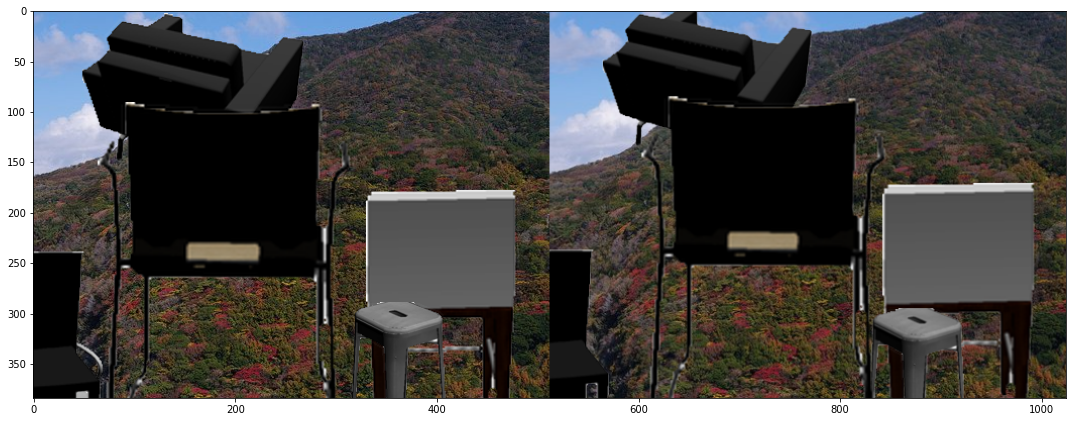

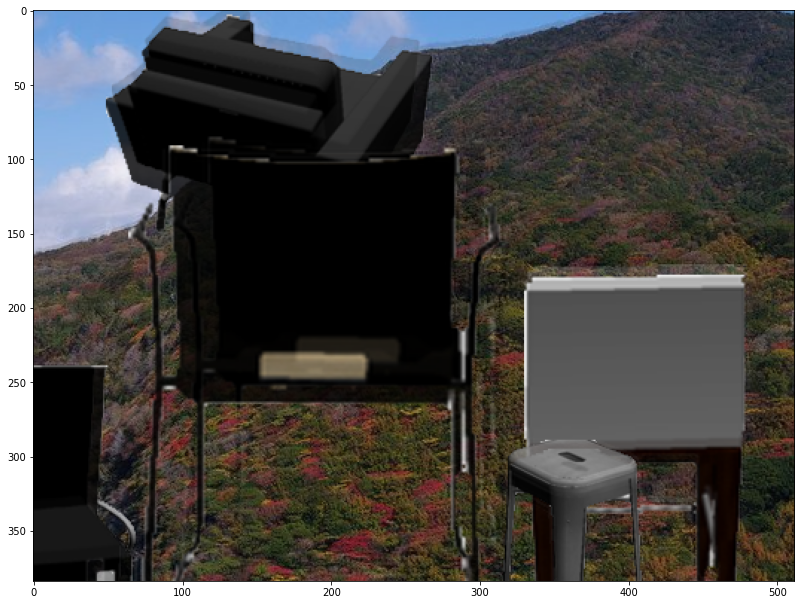

flonwet input: torch.Size([1, 3, 2, 384, 512])


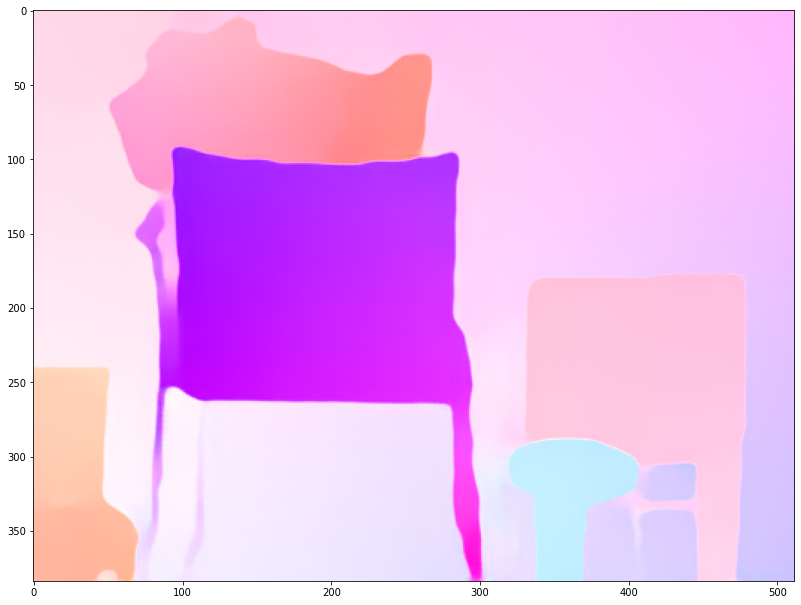

In [ ]:

_im1 = plt.imread('test/img0.ppm')
_im2 = plt.imread('test/img1.ppm')

def viz_diff(_im1, _im2):
    fig = mpl.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.imshow(np.hstack([_im1, _im2]))
    plt.show()
    fig = mpl.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.imshow(cv2.addWeighted(_im1,0.8,_im2,0.2,0))
    plt.show()
    data, out = run_optic_flow(_im1/255, _im2/255)
    fig = mpl.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.imshow(out)
    plt.show()
    return data, out
    
viz_diff(_im1, _im2)
pass

In [ ]:
def resize_to_nearest_pow2(im, sf=1):
    height = int(2**round(math.log(im.shape[0], 2)))
    width = int(2**round(math.log(im.shape[1], 2)))
    return cv2.resize(im, (width//sf, height//sf))

In [ ]:
def imshow(im):
    fig = mpl.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.imshow(im)
    plt.show()
    
    
def imshow_overlay(im1, im2):
    fig = mpl.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.imshow(cv2.addWeighted(im1,0.5,im2,0.5,0))
    plt.savefig('out.png')
    plt.show()
    

In [ ]:
def zero_upscale(im, sf=2):
    out = np.zeros((im.shape[0]*sf, im.shape[1]*sf, im.shape[2]), dtype=np.uint8)
    for r in range(im.shape[0]):
        for c in range(im.shape[1]):
            out[r*sf][c*sf] = im[r][c]
    return out

def lin_upscale(im, sf=2, interp=True):
    return cv2.resize(im, (im.shape[1]*sf, im.shape[0]*sf), interpolation=cv2.INTER_NEAREST if not interp else None)


def motion_compensate2(im1, im2, upscale_fn=lin_upscale, sf=4):
    data, out = run_optic_flow(im1, im2)
    flow = lin_upscale(data, sf)
    
    im1 = upscale_fn(im1, sf)
    im2 = upscale_fn(im2, sf)
    
    out = np.ones(im2.shape, dtype=np.uint8) * 255
    #out = im1.copy()
    for r in range(im2.shape[0]):
        for c in range(im2.shape[1]):
            one2two = flow[r][c]
            dest = (int(round(r+one2two[1]))), int(round(c+one2two[0]))
            destpix = 0
            if 0 <= dest[0] < im2.shape[0] and 0 <= dest[1] < im2.shape[1]:
                out[dest[0]][dest[1]] = im1[r][c]
            
    return out


def motion_compensate3(im1, im2, upscale_fn=lin_upscale, sf=4):
    data, out = run_optic_flow(im1, im2)
    hisf = 2
    flow = lin_upscale(data, sf*hisf)
    
    im1 = upscale_fn(im1, sf)
    im2 = upscale_fn(im2, sf*hisf)
    
    if True:
        # fully vectorized approach is slower as columwise 
        cols = np.array([[i for i in range(im2.shape[1])]]).T
        cols = np.expand_dims(np.tile(cols, im2.shape[0]).T, 2)
        rows = np.array([[i for i in range(im2.shape[0])]]).T
        rows = np.expand_dims(np.tile(rows, im2.shape[1]), 2)
        dirs = np.concatenate((cols, rows), axis=2)
        
        out = np.ones(im1.shape, dtype=np.float32)
        dests = ((dirs + flow + 0.5) / hisf - 0.5).astype(np.uint16)
        np.clip(dests[:, :, 1], 0, im1.shape[0]-1, out=dests[:, :, 1])
        np.clip(dests[:, :, 0], 0, im1.shape[1]-1, out=dests[:, :, 0])
        out[dests[:, :, 1], dests[:, :, 0], :] = lin_upscale(im1, 2, False)
    else:
        # vectorized approach. Compute columnwise motion compensatoin
        out = np.ones(im1.shape, dtype=np.float32)
        cols = np.array([i for i in range(im2.shape[1])])
        for r in range(im2.shape[0]):
            # dests[r, :, 0] --> cdest, dests[r, :, 1] --> rdest
            cdest = ( (np.array(cols+flow[r][:, 0])+0.5) /hisf-0.5 ).astype(np.uint16).T
            rdest = ( (np.array(r+flow[r][:, 1])+0.5) /hisf-0.5 ).astype(np.uint16).T
            rdest[rdest >= im1.shape[0]] = im1.shape[0] - 1
            cdest[cdest >= im1.shape[1]] = im1.shape[1] - 1
            out[rdest, cdest, :] = im1[r//hisf, cols//hisf]
        
    return out

sf = 4
im1 = resize_to_nearest_pow2(frames[50], sf)
im2 = resize_to_nearest_pow2(frames[115], sf)
im12 = motion_compensate3(im1/255, im2/255, lin_upscale, sf)

flonwet input: torch.Size([1, 3, 2, 256, 512])


In [ ]:
class UpsampleZero(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, img, scale_factor):
        """
        IMPORTANT: we only support integer scaling factors for now!!
        """
        # input shape is: batch x channels x height x width
        # output shape is:
        device = img.device
        input_size = torch.tensor(img.size(), dtype=torch.int)
        input_image_size = input_size[2:] # input_image_size[0]-height, input_image_size[1]-width
        data_size = input_size[:2]
        
        # Get the last two dimensions -> height x width
        # compare to given scale factor
        b_ = np.asarray(scale_factor)
        b = torch.tensor(b_)
        # check that the dimensions of the tuples match.
        if len(input_image_size) != len(b):
            raise ValueError("scale_factor should match input size!")
        output_image_size = (input_image_size * b).type(torch.int) # element-wise product

        scale_factor = torch.tensor(np.asarray(scale_factor), dtype=torch.int)
        ##
        output_size = torch.cat((data_size, output_image_size))
        output = torch.zeros(tuple(output_size.tolist()))
        ##
        # todo: use output.view(...) instead.
        output[:, :, ::scale_factor[0], ::scale_factor[1]] = img
        return output.to(device=device)
    
sample = UpsampleZero()
print(t1.shape)
x = sample.forward(t1, [2, 2])
print(x.shape)
x = x.cpu()[0,...].transpose(0, 1).transpose(1, 2)
imshow(x)


NameError: name 't1' is not defined

In [ ]:
class BackwardWarper(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x_image, x_motion):
        """ Stolen from github nsrr-reimplementation """

        index_batch, _, height, width = x_image.size()
        grid_x = torch.arange(width).view(1, -1).repeat(height, 1)
        grid_y = torch.arange(height).view(-1, 1).repeat(1, width)
        grid_x = grid_x.view(1, 1, height, width).repeat(index_batch, 1, 1, 1)
        grid_y = grid_y.view(1, 1, height, width).repeat(index_batch, 1, 1, 1)
        ##  
        grid = torch.cat((grid_x, grid_y), 1).float().to(device=x_motion.device)
        # grid is: [batch, channel (2), height, width]
        vgrid = grid + x_motion
        # Grid values must be normalised positions in [-1, 1]
        vgrid_x = vgrid[:, 0, :, :]
        vgrid_y = vgrid[:, 1, :, :]
        vgrid[:, 0, :, :] = (vgrid_x / width) * 2.0 - 1.0
        vgrid[:, 1, :, :] = (vgrid_y / height) * 2.0 - 1.0

        # swapping grid dimensions in order to match the input of grid_sample.
        # that is: [batch, output_height, output_width, grid_pos (2)]
        vgrid = vgrid.permute((0, 2, 3, 1)).to(device=x_image.device)
        output = torch.nn.functional.grid_sample(x_image, vgrid, mode='nearest', align_corners=False)
        return output

def torch_compensate(img, flow, sf=4, use_cuda=False):
    """ 
    Warps and upscales a batch of images, given a batch of flows. 
    
    Args:
        img:  (N, C, H, W) image to be warped
        flow: (N, 2, H, W) flow to be used in warping
        sf:   scale-factor to upscale the warped result by
    """
    
    # Local parameter used to hyper-upscale flow for better precision
    hisf = 2
    
    flow = nn.functional.interpolate(flow, scale_factor=sf*hisf, mode='bilinear')
    img = nn.functional.interpolate(img, scale_factor=sf, mode='bilinear')
    img_2 = nn.functional.interpolate(img, scale_factor=2, mode='nearest')
    
    
    # create unwarped index matrix
    ncols = flow.shape[3]
    nrows = flow.shape[2]
    rows = np.array([[i for i in range(nrows)]]).T
    rows = np.expand_dims(np.tile(rows, ncols).T, 2)
    cols = np.array([[i for i in range(ncols)]]).T
    cols = np.expand_dims(np.tile(cols, nrows), 2)
    dirs = np.concatenate((cols, rows), axis=2)
    dirs = torch.tensor(dirs).unsqueeze(0).transpose(1, -1)
    
    # create output tensor or re-use img
    out = torch.ones(img.shape).double()
    # out = img
    
    if use_cuda:
        out = out.cuda()
        dirs = dirs.cuda()
        
    # compute warped indices for batch
    dests = ((dirs + flow + 0.5) / hisf - 0.5).long()
    torch.clip(dests[:, 1, :, :], 0, out.shape[2]-1, out=dests[:, 1, :, :])
    torch.clip(dests[:, 0, :, :], 0, out.shape[3]-1, out=dests[:, 0, :, :])
    
    # This could maybe be optimized
    for b in range(dests.shape[0]):
        out[b, :, dests[b, 1, :, :], dests[b, 0, :, :]] = img_2[b, ...]
    
    return out

In [ ]:
data, out = run_optic_flow(im1/255, im2/255)
t1 = np.transpose(im1, [2, 0, 1])
t2 = np.transpose(im2, [2, 0, 1])
t1 = torch.from_numpy(t1/255)
t2 = torch.from_numpy(t2/255)
data = np.transpose(data, [2, 0, 1])
flow = torch.from_numpy(data)

use_cuda = True 

# batch size of 4
test_batch_size = 2
flow = torch.stack((flow,)*test_batch_size)
t1 = torch.stack((t2,)*test_batch_size)
if use_cuda:
    flow = flow.cuda()
    t1 = t1.cuda()
    
x = np.ones((3,3))
print("Checkerboard pattern:")
index_batch, _, height, width = t1.size()
x = np.zeros((height,width),dtype=np.float64)
x[1::1,::2] = 1
x[::2,1::1] = 1
x = cv2.resize(x, (width, height), interpolation=cv2.INTER_NEAREST)
test_img = torch.from_numpy(x).unsqueeze(0).unsqueeze(0).cuda()
#t1 = test_img
st = time.time()
mine = torch_compensate(t1, flow, use_cuda=use_cuda).cpu()
et = time.time()
print('dt', et - st)
warper = BackwardWarper()
print(t1.shape)
st = time.time()
res = warper(t1.double(), flow.double()/255).cpu()
et = time.time()
print('dt', et - st)
print(flow.shape)
print(t1.shape)

flonwet input: torch.Size([1, 3, 2, 256, 512])
Checkerboard pattern:
dt 0.31930088996887207
torch.Size([2, 3, 256, 512])
dt 0.003974199295043945
torch.Size([2, 2, 256, 512])
torch.Size([2, 3, 256, 512])


In [ ]:
print(res.std())
(im2/255).std()

tensor(0.2676, dtype=torch.float64)


0.2661950863844196

tensor(0.3789, dtype=torch.float64)


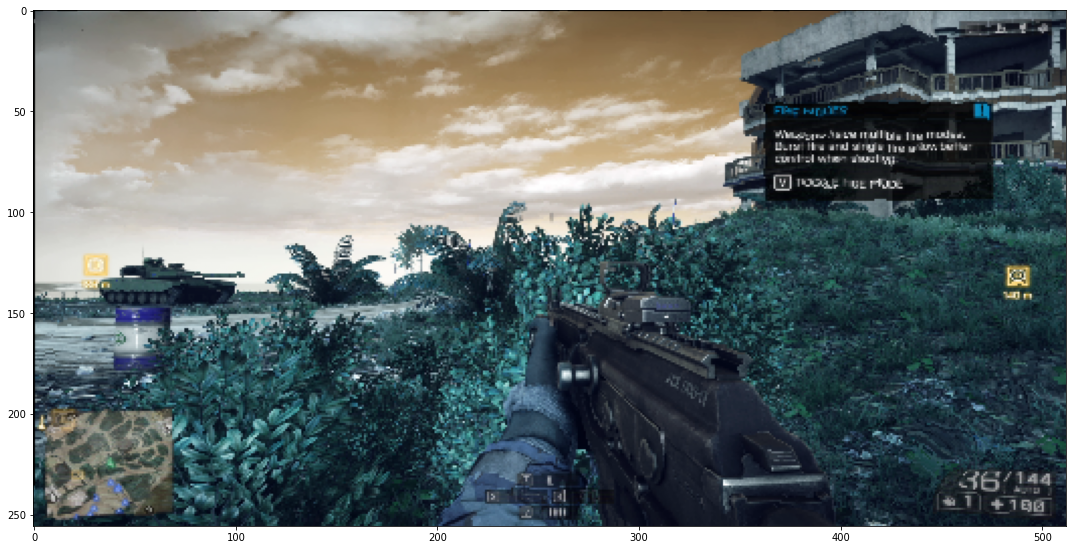

In [ ]:
x = res[1, ...]
x = x.transpose(0, 1).transpose(1, 2)
print(x.mean())
imshow(x)

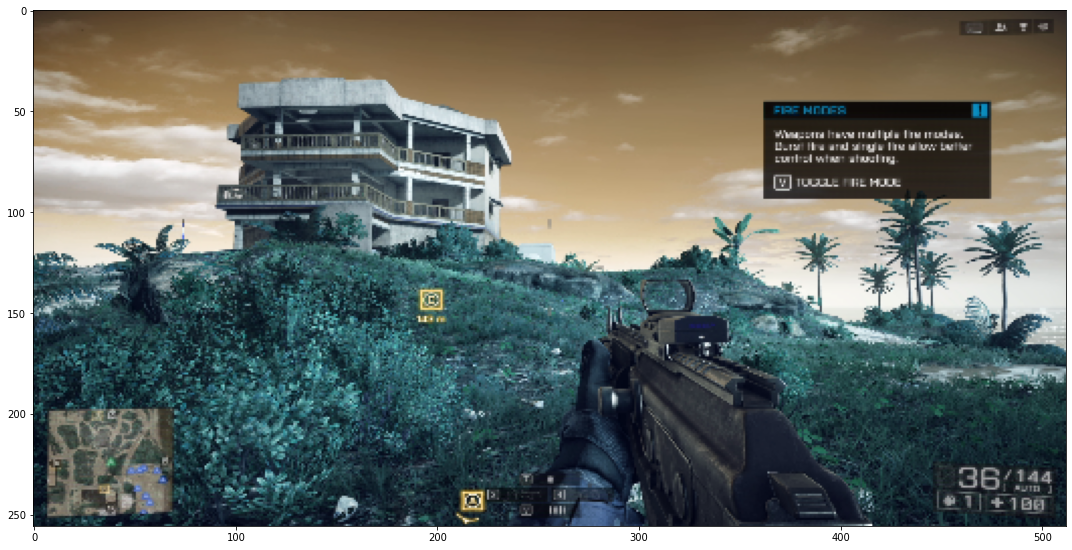

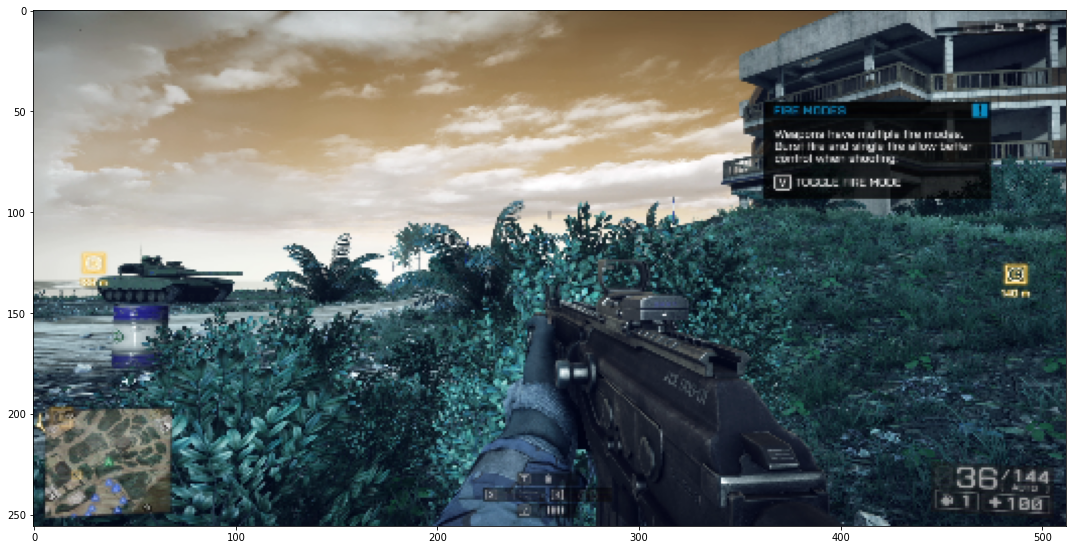

In [ ]:
imshow(im1)
imshow(im2)

tensor(0.4325, dtype=torch.float64)


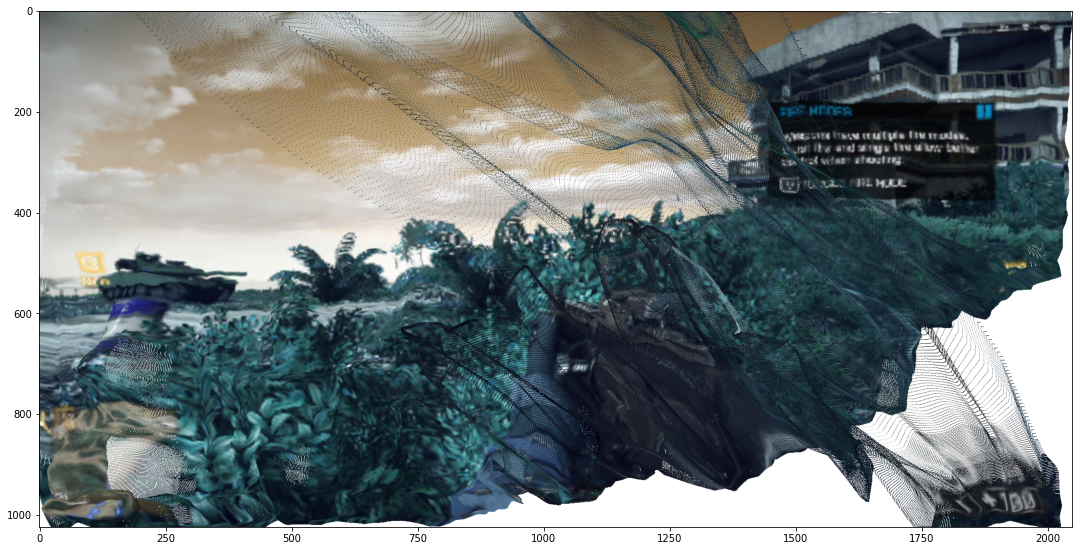

In [ ]:

x = mine[0, ...]
x = x.transpose(0, 1).transpose(1, 2)
print(x.mean())
imshow(x)

In [ ]:
class LossMaker():
    def __init__(self):
        self.features = list(models.vgg16(pretrained=True).features)[:23]
        self.features = torch.nn.ModuleList(self.features).cuda(1).eval()
        self.ssim_module = pytorch_msssim.SSIM(data_range=255, size_average=True, channel=3)

    def perceptual_loss(self, out, ref):
        layers = {15}
        
        # make sure we have gradient on output for gradient of loss calculation
        if not out.requires_grad:
            out = torch.autograd.Variable(out, requires_grad=True)
            
        fout = self.get_perceptual_features(out, layers_to_pick_from=layers)
        fref = self.get_perceptual_features(ref, layers_to_pick_from=layers)
        loss = 0
        for i in range(len(fout)):
            loss += fout[i].dist(fref[i], p=2) / torch.numel(fref[i])
        return loss
    
    def get_perceptual_features(self, x, layers_to_pick_from={3,8,15,22}):
        results = []
        for ii,model in enumerate(self.features):
            if ii > max(layers_to_pick_from): break
            x = model(x)
            if ii in layers_to_pick_from:
                results.append(x)
        return results
    
    def ssim_loss(self, out, ref):
        
        if len(out.shape) != len(ref.shape): 
            assert "Out and ref must have same dim count"
            
        if len(out.shape) == 3: 
            if type(out) == torch.Tensor:
                out = out.unsqueeze(0)
                ref = ref.unsqueeze(0)
            elif type(out) == np.ndarray:
                out = np.expand_dims(out, 0)
                ref = np.expand_dims(ref, 0)
                
        # make sure we have gradient on output for gradient of loss calculation
        if not out.requires_grad:
            out = torch.autograd.Variable(out, requires_grad=True)
            
        return self.ssim_module(out, ref)
     
    def total_loss(self, out, ref): 
        return 1 - self.ssim_loss(out, ref) - 0.1 * self.perceptual_loss(out, ref)

In [ ]:
loss_maker = LossMaker()    

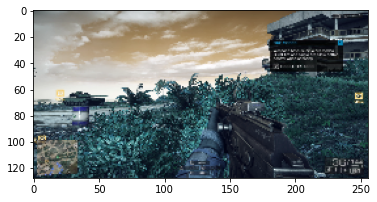

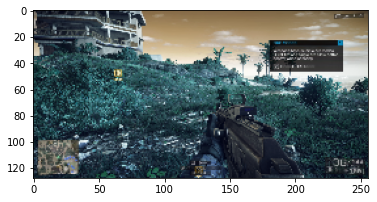

perceptual_loss tensor(0.0032, device='cuda:1', grad_fn=<AddBackward0>)
ssim_loss tensor(0.9897, device='cuda:1', grad_fn=<MeanBackward0>)
total_loss tensor(0.0100, device='cuda:1', grad_fn=<SubBackward0>)


In [ ]:
f1 = resize_to_nearest_pow2(frames[110], 8)
f2 = resize_to_nearest_pow2(frames[0], 8)
plt.imshow(f1)
plt.show()
plt.imshow(f2)
plt.show()
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
f1 = transform(f1).cuda(1)
f2 = transform(f2).cuda(1)
fout = loss_maker.perceptual_loss(f1, f2)
ssim_loss = loss_maker.ssim_loss(f1, f2)
total_loss = loss_maker.total_loss(f1, f2)
print('perceptual_loss', fout)
print('ssim_loss', ssim_loss)
print('total_loss', total_loss)

In [ ]:
f1.shape

torch.Size([3, 128, 256])

In [ ]:
class FeatureExtractionNet(nn.Module):
    def __init__(self, kernel_size=3, padding='same'):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=kernel_size, padding=padding),
            nn.ReLU()
        )
        
    def forward(self, rgbd_tensor):
        # rgbd_tensor: (N, C, H, W) where C = R, G, B, D channels
        full_features = self.net(rgbd_tensor)
        channel_dim = len(rgbd_tensor.shape)-1-2
        return torch.concat((rgbd_tensor, full_features), dim=channel_dim)

class FeatureReweightingNet(nn.Module):
    '''Adopted from nsrr github'''
    def __init__(self, kernel_size=3, padding='same', scale=10):
        super().__init__()

        self.scale = scale
        self.net = nn.Sequential(
            # We think of the input as the concatanation of RGB-Ds of current frame, which has 4 channles
            # and full features of previous frames, each of which has 12 channels
            # so `in_channels=20`, which is 4+4*12 = 52
            # To save memory, we have to feed the upsampled RGB-D to compute a weight and calculate the weighted sum of the 12 channels
            nn.Conv2d(in_channels=4*5, out_channels=32, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=4, kernel_size=kernel_size, padding=padding),
            nn.Tanh()
        )
        
    def forward(self, current_rgbd_scaled, previous_features):
        stacked_reweighted_rgbds = torch.cat([
            current_rgbd_scaled.unsqueeze(1)[:, :, 0:4, ...], 
            previous_features[:, :, 0:4, ...] 
        ], dim=1)
        stacked_reweighted_rgbds = stacked_reweighted_rgbds.flatten(1, 2)
        
        w = self.net(stacked_reweighted_rgbds)
        w = (w-(-1))/2*self.scale # Scale
        
        weighted_previous_features = [w[:,i,:,:].unsqueeze(1)*previous_features[:, i, ...] for i in range(4)] # Reweighting
        return weighted_previous_features

class ReconstructionNet(nn.Module):
    '''Adopted from NSRR github repo'''
    def __init__(self, kernel_size=3, padding='same'):
        super().__init__()
        self.pooling = nn.MaxPool2d(2)

        # Split the network into 5 groups of 2 layers to apply concat operation at each stage
        # todo: the first layer of the model would take
        # the concatenated features of all previous frames,
        # so the input number of channels of the first 2D convolution
        # would be 12 * self.number_previous_frames
        self.encoder_1 = nn.Sequential(
            nn.Conv2d(12*4+12, 64, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=kernel_size, padding=padding),
            nn.ReLU()
        )
        self.encoder_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=kernel_size, padding=padding),
            nn.ReLU()
        )
        self.center = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),

        )
        self.decoder_1 = nn.Sequential(
            nn.Conv2d(128+64, 64, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
        self.decoder_2 = nn.Sequential(
            nn.Conv2d(32+64, 32, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, current_features, reweighted_previous_features):
        # Features of the current frame and the reweighted features
        # of previous frames are concatenated
        
        reconstruction_inp = torch.cat([
            current_features.unsqueeze(1), 
            reweighted_previous_features
        ], dim=1)
        reconstruction_inp = reconstruction_inp.flatten(1, 2)

        channel_dim = 1
   
        out_encoder_1 = self.pooling(self.encoder_1(reconstruction_inp))
        
        out_encoder_2 = self.pooling(self.encoder_2(out_encoder_1))
        
        out_center = self.center(out_encoder_2)
        
        out_decoder_1 = self.decoder_1(torch.concat((out_center, out_encoder_2), dim=channel_dim))

        out_decoder_2 = self.decoder_2(torch.concat((out_encoder_1, out_decoder_1), dim=channel_dim))

        return out_decoder_2

In [ ]:
fen = FeatureExtractionNet()
fen.eval()

FeatureExtractionNet(
  (net): Sequential(
    (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
  )
)

In [ ]:
class NSRR(nn.Module):
    def __init__(self, fnet):
        super().__init__()
        self.past_fextractor = fnet #FeatureExtractionNet()
        self.current_fextractor = FeatureExtractionNet()
        self.upsample_zero = UpsampleZero()
        self.upsample_factor = 4 
        self.backward_warp = BackwardWarper()
        self.reweighter = FeatureReweightingNet()
        self.reconstructer = ReconstructionNet()
        
        self.past_fextractor.cuda()
        self.reweighter.cuda()
    
    def forward(self, rgbds, flows): 
        current_rgbd = rgbds[:, -1, ...]
        current_features = self.current_fextractor(current_rgbd)
        current_features = self.upsample_zero(current_features,  [self.upsample_factor]*2)
        
        input_shape = torch.tensor(current_rgbd.shape[-2:])
        
        past_rgbds = rgbds[:, 0:-1, ...]
        past_features = torch.empty([batch_size, 4, 12] + (input_shape*self.upsample_factor).tolist())
        for i in range(4): 
            past = past_rgbds[:, i, ...]
            past_feature = self.past_fextractor(past)
            past_feature = self.upsample_zero(past_feature, [self.upsample_factor]*2)
            past_features[:, i, ...] = past_feature
        
        # past_features[0] -> frame i-4
        # past_features[1] -> frame i-3
        # past_features[2] -> frame i-2
        # past_features[3] -> frame i-1
        # current_features -> frame i 
        
        flows = torch.nn.functional.interpolate(flows.flatten(0, 1), 
                                                scale_factor=self.upsample_factor, 
                                                mode='bilinear')
        flows = flows.unflatten(0, (batch_size, 4))
        
        
        # Do Accumulative backward warping in batches
        # Frame i-1 gets warped into frame i using flow(i-1 --> i)
        # Frame i-2 gets warped into frame i using flow(i-2 --> i-1) and then flow(i-1 --> i)
        # Frame i-3 gets warped into frame i using flow(i-3 --> i-2), flow(i-2 --> i-1), flow(i-1 --> i)
        # Frame i-4 gets warped into frame i using flow(i-4 --> i-3), ..., flow(i-1 --> i)
        done_warped = [None] * 4
        warped = past_features
        for i in range(4):
            to_warp = warped[:, 0:4-i, ...].flatten(0, 1)
            warp_flows = flows[:, i:4, ...].flatten(0, 1)
            warped = self.backward_warp(to_warp, warp_flows)
            warped = warped.unflatten(0, (batch_size, 4-i))
            done_warped[3-i] = warped[:, 3-i, ...]
            
        # done_warped[0] --> zero upscaled, acc. warped frame_minus_4
        # done_warped[1] --> zero upscaled, acc. warped frame_minus_3
        # done_warped[2] --> zero upscaled, acc. warped frame_minus_2
        # done_warped[3] --> zero upscaled, warped frame_minus_1
        
        # Create input to Feature Reweighting network
        done_warped = torch.stack(done_warped, dim=1).cuda()
        current_rgbd_scaled = current_features[:, 0:4, ...]
        
        reweighted = self.reweighter(current_rgbd_scaled, done_warped)
        reweighted = torch.stack(reweighted, dim=1).cuda() 
        
        reconstructed = self.reconstructer(current_features, reweighted)
        
        return reconstructed 
        
        

In [ ]:
rgbd.shape
x = rgbd[0, 0, 0, ...]
y = rgbd[1, 0, 0, ...]

f = rgbd.flatten(0, 1)

a = f[0, 0, ...]
b = f[5, 0, ...]

y == b



tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')

In [ ]:
fext = FeatureExtractionNet()
nsrr = NSRR(fext)
nsrr.cuda()

NSRR(
  (past_fextractor): FeatureExtractionNet(
    (net): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU()
      (4): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (5): ReLU()
    )
  )
  (current_fextractor): FeatureExtractionNet(
    (net): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU()
      (4): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (5): ReLU()
    )
  )
  (upsample_zero): UpsampleZero()
  (backward_warp): BackwardWarper()
  (reweighter): FeatureReweightingNet(
    (net): Sequential(
      (0): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1),

In [ ]:
x = nsrr(rgbd.cuda(), flows.cuda())

reconstrifcon inp
torch.Size([2, 3, 512, 1024])
past_features#: 2
past_features[0] torch.Size([4, 12, 512, 1024])


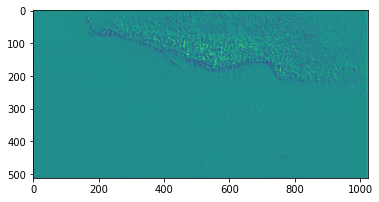

In [ ]:
plt.imshow(x.cpu().detach().numpy()[1, 0, :, :])

In [ ]:
frame_minus_1 = x[3].cpu()
frame_minus_2 = x[2].cpu()
frame_minus_3 = x[1].cpu()
frame_minus_4 = x[0].cpu()

In [ ]:
x.shape

torch.Size([2, 3, 512, 1024])

In [ ]:
frame_i = 3             # 0 --> frame_minus_4,  1 --> frame_minus_3,   2 --> frame_minus_2,   3 --> frame_minus_1

ups = UpsampleZero()
warp = BackwardWarper()
fm1 = fext.cpu()(rgbd[:, frame_i, ...])
warped = ups(fm1, [4, 4])

for i in range(frame_i, 4):
    warped = warp(warped, torch.nn.functional.interpolate(flows[:, i, ...], scale_factor=4, mode='bilinear'))

out = warped

In [ ]:
torch.max(abs(out - frame_minus_1))

tensor(2.2352e-07, grad_fn=<MaxBackward1>)

tensor(False)

tensor(1.1176e-07, grad_fn=<MaxBackward1>)